 # Bifurcation Prediction Model
 This notebook trains and tests several regression models to predict the optimum bifurcation point for a terminal node/segment pair. 

### Import Modules

In [1]:
#Import basic modules
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import time
import numpy as np

#Import ML modules
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from sklearn import preprocessing
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import RFECV

## Data Processing
We will load the dataset from the 06_Data directory (stored in author's pc) and load the dataset. Determine which dataset to load by specifying in the 'load_path' line.

In [2]:
#Change directory to 06_Data folder
os.chdir('../../06_Data')
print(os.getcwd())

/Users/taigakobayashi/OneDrive - University of Bath/FYP/06_Data


In [3]:
#Read dataset path as pandas dataframe
load_path = (os.getcwd() + "/ProcessedData/WP2T1/3000_seg_enriched_dataset.csv")#change to desired load path

#Load file as pandas dataframe
df = pd.read_csv(load_path,dtype={'beta': object}) #Specify 'beta' column as object as it contains imaginary numbers

#See summary of dataframe
df.head()

,Unnamed: 0,Px,Py,D1x,D1y,D2x,D2y,Radius,circleradius,totseg,...,GPx,GPy,OrigSeg,l1,l2,l3,beta,alpha,Bifx,Bify
0,0,0.003365,0.002243,0.003175,0.000979,0.0,0.0,5,0.003162,12,...,-0.000032,0.000632,1,0.000633,0.000470,0.001279,168.61,39.196,0.003182,0.001652
1,1,0.002201,-0.000643,0.001378,-0.001301,0.0,0.0,3,0.003291,13,...,-0.000329,0.001316,1,0.001357,0.000736,0.001054,114.62,77.905,0.001729,-0.000841
2,2,-0.003325,0.004009,-0.002983,0.002643,0.0,0.0,13,0.003415,14,...,-0.003415,-0.006830,1,0.000000,0.000000,0.000000,0.0,0.000,-0.003266,0.003222
3,3,0.003965,-0.000743,0.000408,-0.002590,0.0,0.0,1,0.003535,15,...,0.000205,0.000661,0,0.000692,0.000753,0.004008,134.69,62.048,0.001881,-0.001184
4,4,-0.002749,0.000490,0.000743,-0.002955,0.0,0.0,1,0.003651,16,...,-0.000063,0.000841,0,0.000844,0.000689,0.004905,138.86,19.348,-0.001194,-0.000346


Some points contain NaN values due to errors in MATLAB output and concatenation

In [4]:
#Display number of NaN rows
print('NaN count:',df.isna().values.sum())

#Remove NaN rows
df = df.dropna()

#It should display 'NaN count: 0' here
print('NaN count:',df.isna().values.sum())

#Check shape of dataframe
df.shape

NaN count: 0
(299000, 22)
NaN count: 0


(299000, 22)

Due to errors in MATLAB code generation, there are some values in Beta (e.g. '180-28i') that need to be removed. Column 'beta' can then be converted to a float column

In [5]:
#Display number of rows to remove due to a row in 'beta' being imaginary
print(df[df['beta'].str.contains("i")].beta.count(),'rows removed out of',df.shape[0])

#Remove rows containing 'i' 
df = df[~df['beta'].str.contains("i")]

#Convert column 'beta' into a column of type float
df.beta = df.beta.astype(float)

#Show summary of dataframe
df.info()
df.shape

126 rows removed out of 299000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 298874 entries, 0 to 298999
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    298874 non-null  int64  
 1   Px            298874 non-null  float64
 2   Py            298874 non-null  float64
 3   D1x           298874 non-null  float64
 4   D1y           298874 non-null  float64
 5   D2x           298874 non-null  float64
 6   D2y           298874 non-null  float64
 7   Radius        298874 non-null  int64  
 8   circleradius  298874 non-null  float64
 9   totseg        298874 non-null  int64  
 10  P2x           298874 non-null  float64
 11  P2y           298874 non-null  float64
 12  GPx           298874 non-null  float64
 13  GPy           298874 non-null  float64
 14  OrigSeg       298874 non-null  int64  
 15  l1            298874 non-null  float64
 16  l2            298874 non-null  float64
 17  l3            298

(298874, 22)

In [7]:
#Optional step - to output processed dataframe for use in MATLAB ML model
df.to_csv(os.getcwd() + "/ProcessedData/WP2T1/3000_seg_enriched_dataset_processed.csv")

### Optional Normalisation step
This normalises connection points Px, Py, D1x, D1y, Bifx, Bify, GPx, GPy, P2x and P2y in hopes of a more accurate representation of errors computed in the regression model. The normalised connection points are now all represented as a distance percentage relative to the range.

In [1]:
#Define the x and y range of the allocated area
rangex = df[['Px','D1x','D2x']].max(axis=1) - df[['Px','D1x','D2x']].min(axis=1)
rangey = df[['Py','D1y','D2y']].max(axis=1) - df[['Py','D1y','D2y']].min(axis=1)

#Divide all connection points by range x and y
df[['Bifx','Px','D1x','GPx','P2x']] = df[['Bifx','Px','D1x','GPx','P2x']].divide(rangex,axis=0)
df[['Bify','Py','D1y','GPy','P2y']] = df[['Bify','Py','D1y','GPy','P2y']].divide(rangey,axis=0)

#Drop any NaN rows resulting from this calculation
print('NaN count:',df.isna().values.sum())
df = df.dropna()

#Summarise dataframe with normalised connections
df.head()

NameError: name 'df' is not defined

In [21]:
#Optional step - to output processed dataframe for use in MATLAB ML model for normalised features
df.to_csv(os.getcwd() + "/ProcessedData/WP2T1/3000_seg_enriched_dataset_normalised.csv")

## Setting features and labels
We will start with all features generated on the MATLAB code.
Our labels are Bifx and Bify, corresponding to the x and y coordinates of the bifurcation point respectively

In [7]:
#Identify bifurcation points as target y
labels = ['Bifx','Bify']
y = df[labels] 

#identify features x
features = ['D1x', 'D1y', 'Px', 'Py','Radius','circleradius','totseg','P2x','P2y','GPx','GPy','OrigSeg','l1','l2','l3','beta','alpha']
X = df[features]

#print the shape of features and labels to see if they are appropriate
print('X size: ', X.shape)
print('y size: ', y.shape)

#Show summary of feature dataframe
X.head()

X size:  (8910, 17)
y size:  (8910, 2)


,D1x,D1y,Px,Py,Radius,circleradius,totseg,P2x,P2y,GPx,GPy,OrigSeg,l1,l2,l3,beta,alpha
0,0.938275,0.415783,1.000000,1.000000,5.0,0.017235,12.0,-0.113183,-0.146033,-0.010327,0.292151,1.0,0.003451,0.002562,0.006971,168.61,39.196
1,0.627191,-1.000000,1.000000,-0.438215,3.0,0.017938,13.0,0.149157,-0.561785,-0.149157,1.123884,1.0,0.007396,0.004011,0.005743,114.62,77.905
2,0.201092,-1.000000,1.000000,-0.124810,1.0,0.018615,14.0,-0.012826,-0.373105,0.038895,0.332638,0.0,0.003609,0.003946,0.019569,131.62,57.820
3,-0.893495,0.679834,-1.000000,1.000000,14.0,0.019269,15.0,-1.064998,-1.600748,-1.064998,-1.600748,1.0,0.000000,0.000000,0.000000,0.00,0.000
4,0.233624,-0.881298,-0.766376,0.118702,1.0,0.019901,16.0,0.079345,-0.150851,-0.030382,0.249008,0.0,0.004988,0.003330,0.026930,144.01,16.734


## Regression model setup
We will be using 5 models:
* Linear regressor
* Decision tree regressor
* Random forest regressor
* XGBoost regressor
* Neural Network

### Standard models


In [8]:
#Import modules
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

#Define regression models
LinearRegressor_model = LinearRegression()
TreeRegressor_model = DecisionTreeRegressor()
RFRegressor_model = RandomForestRegressor(n_estimators = 128)
XGBRegressor_model = MultiOutputRegressor(XGBRegressor(n_estimators = 128))

### Neural Network
The neural network will have one hidden layer, with a ReLu activation function that has been shown to be the best one for regression predictions. The output layer does not have an activation function as it must output a continuous value.

In [2]:
# define base model
def baseline_model():
    
    # create model using keras layers
    model = Sequential() #Define keras model
    model.add(Dense(X.shape[1], input_dim=X.shape[1], activation='relu')) #input layer
    model.add(Dense(X.shape[1],activation='relu')) #hidden layer
    model.add(Dense(2)) #output layer (2 neurons for x and y bif point)
    
    # Compile model
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

# evaluate model
NNRegressor_model = KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=50, verbose=1)

NameError: name 'KerasRegressor' is not defined

## Training & Testing models
Each model will be trained and its performance evaluated with 10 fold cross validation. 

In [10]:
#Create an array of regression models to loop through
regression_models = [LinearRegressor_model,
                     TreeRegressor_model,
                     RFRegressor_model,
                     XGBRegressor_model,
                     NNRegressor_model
                    ]

#Similar to the above but with the names in the form of strings
regression_model_name = ['LinearRegressor_model',
                         'TreeRegressor_model',
                         'RFRegressor_model',
                         'XGBRegressor_model',
                         'NNRegressor_model'
                        ]

In [11]:
#Split dataframe into train and test dataset for use in final prediction evaluation
traindf=df.sample(frac=0.8,random_state=200) #random state is a seed value
testdf=df.drop(traindf.index).reset_index(drop=True)

#Redefine features and labels for train and test dataset
y_train = traindf[labels]
X_train = traindf[features]
y_test = testdf[labels]
X_test = testdf[features]

In [12]:
#train and validate each model using a 10-fold cross validation
for model,model_name in zip(regression_models,regression_model_name):
    
    #Start timer to measure training time
    starttime = time.time()

    #Cross validate models (fit + calculate error for each fold) and compute average error score
    score = -(cross_val_score(model,X,y,cv=10,scoring='neg_mean_absolute_error'))
    
    #Find prediction computing time by validating on test dataset
    model.fit(X_train,y_train)
    pred_starttime = time.time()
    predictions = model.predict(X_test)
    pred_endtime = time.time()
    endtime = time.time()
    
    #Print results
    print(model_name,'training time:',str(endtime-starttime),'prediction time:',str(pred_endtime-pred_starttime))
    print('             cross validation error: ',score.mean())
    print('             cross validation std dev: ',score.std())   

LinearRegressor_model training time: 0.3711280822753906 prediction time: 0.004683971405029297
             cross validation error:  0.06597330450753117
             cross validation std dev:  0.0013172421692533784
TreeRegressor_model training time: 2.234699010848999 prediction time: 0.005164623260498047
             cross validation error:  0.06103013021189295
             cross validation std dev:  0.001593239626999105
RFRegressor_model training time: 154.51014614105225 prediction time: 0.13533711433410645
             cross validation error:  0.042385408395724085
             cross validation std dev:  0.0013051318355229938
XGBRegressor_model training time: 88.40206098556519 prediction time: 0.016638994216918945
             cross validation error:  0.04217334681462712
             cross validation std dev:  0.0011603555416015853
Epoch 1/50
161/161 [==============================] - 0s 2ms/step - loss: 2.6377
Epoch 2/50
161/161 [==============================] - 0s 2ms/step - loss: 0

Epoch 40/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0786
Epoch 41/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0792
Epoch 42/50
161/161 [==============================] - 0s 1ms/step - loss: 0.0784
Epoch 43/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0780
Epoch 44/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0808
Epoch 45/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0805
Epoch 46/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0784
Epoch 47/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0761
Epoch 48/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0805
Epoch 49/50
161/161 [==============================] - 0s 1ms/step - loss: 0.0765
Epoch 50/50
18/18 [==============================] - 0s 1ms/step
Epoch 1/50
161/161 [==============================] - 0s 2ms/step - loss: 0.9461
Epoch 2/50
161/161 [==============

161/161 [==============================] - 0s 2ms/step - loss: 0.0795
Epoch 37/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0786
Epoch 38/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0780
Epoch 39/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0774
Epoch 40/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0798
Epoch 41/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 42/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0798
Epoch 43/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0825
Epoch 44/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0805
Epoch 45/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0741
Epoch 46/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0772
Epoch 47/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0829
Epoch 48/50
161/161 [=======

161/161 [==============================] - 0s 2ms/step - loss: 0.0824
Epoch 32/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0886
Epoch 33/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0954
Epoch 34/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0999
Epoch 35/50
161/161 [==============================] - 0s 2ms/step - loss: 0.1071
Epoch 36/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0818
Epoch 37/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0849
Epoch 38/50
161/161 [==============================] - 0s 2ms/step - loss: 0.1045
Epoch 39/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0875
Epoch 40/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0903
Epoch 41/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0822
Epoch 42/50
161/161 [==============================] - 0s 2ms/step - loss: 0.0940
Epoch 43/50
161/161 [=======

### Make predictions for test dataset

In [13]:
#Define prediction dataframe
pred_df = []

#predict for all models
for model,model_name in zip(regression_models,regression_model_name):
    
    #Make prediction with test dataset
    starttime = time.time()
    predictions = model.predict(X_test)
    endtime = time.time()
    
    #Append predictions for each model into 'test' dataframe 
    pred_df = pd.DataFrame(data = predictions, columns=['Bifx_pred_' + str(model_name),'Bify_pred_' + str(model_name)])
    testdf = pd.concat([testdf,pred_df],axis=1)

    #evaluate error of prediction
    print(model_name,' error: ',mean_absolute_error(y_test, predictions),'computation time: ',str(endtime-starttime))

#display summary of test dataframe
testdf.head()

LinearRegressor_model  error:  0.06549734552345132 computation time:  0.004389286041259766
TreeRegressor_model  error:  0.060769334931472234 computation time:  0.0023832321166992188
RFRegressor_model  error:  0.04274404227914008 computation time:  0.1593630313873291
XGBRegressor_model  error:  0.04188607175847148 computation time:  0.01821422576904297
36/36 [==============================] - 0s 2ms/step
NNRegressor_model  error:  0.08192701580662157 computation time:  0.19259214401245117


,Unnamed: 0,Px,Py,D1x,D1y,D2x,D2y,Radius,circleradius,totseg,...,Bifx_pred_LinearRegressor_model,Bify_pred_LinearRegressor_model,Bifx_pred_TreeRegressor_model,Bify_pred_TreeRegressor_model,Bifx_pred_RFRegressor_model,Bify_pred_RFRegressor_model,Bifx_pred_XGBRegressor_model,Bify_pred_XGBRegressor_model,Bifx_pred_NNRegressor_model,Bify_pred_NNRegressor_model
0,2,1.0,-0.124810,0.201092,-1.000000,0.0,0.0,1.0,0.018615,14.0,...,0.536140,-0.399812,0.418146,-0.294074,0.453084,-0.347250,0.453077,-0.388447,0.512765,-0.335198
1,5,1.0,0.399409,0.246810,1.000000,0.0,0.0,1.0,0.020513,17.0,...,0.543147,0.549947,0.500473,0.588955,0.541758,0.521290,0.517239,0.506483,0.519263,0.598188
2,18,1.0,0.667890,0.644745,-0.332110,0.0,0.0,1.0,0.027250,30.0,...,0.681992,0.154569,0.659739,0.006817,0.688469,0.051741,0.686930,0.000946,0.694749,0.230783
3,20,1.0,0.946706,0.548073,1.000000,0.0,0.0,1.0,0.028144,32.0,...,0.627882,0.756787,0.639675,0.699152,0.609133,0.755498,0.609251,0.838493,0.622556,0.800780
4,29,1.0,1.000000,0.712351,0.506658,0.0,0.0,1.0,0.031857,41.0,...,0.701132,0.612838,0.715352,0.554193,0.721413,0.565976,0.736662,0.582480,0.675878,0.690208


### Evaluate errors based on Euclidean distance

In [14]:
#normalise features to evaluate normalised error (if it hasn't already been normalised)
rangex = testdf[['Px','D1x','D2x']].max(axis=1) - testdf[['Px','D1x','D2x']].min(axis=1)
rangey = testdf[['Py','D1y','D2y']].max(axis=1) - testdf[['Py','D1y','D2y']].min(axis=1)

testdf.iloc[:,[1,3,20,22,24,26,28,30]] = testdf.iloc[:,[1,3,20,22,24,26,28,30]].divide(rangex,axis=0)
testdf.iloc[:,[2,4,21,23,25,27,29,31]] = testdf.iloc[:,[2,4,21,23,25,27,29,31]].divide(rangey,axis=0)

testdf.head()

,Unnamed: 0,Px,Py,D1x,D1y,D2x,D2y,Radius,circleradius,totseg,...,Bifx_pred_LinearRegressor_model,Bify_pred_LinearRegressor_model,Bifx_pred_TreeRegressor_model,Bify_pred_TreeRegressor_model,Bifx_pred_RFRegressor_model,Bify_pred_RFRegressor_model,Bifx_pred_XGBRegressor_model,Bify_pred_XGBRegressor_model,Bifx_pred_NNRegressor_model,Bify_pred_NNRegressor_model
0,2,1.0,-0.124810,0.201092,-1.000000,0.0,0.0,1.0,0.018615,14.0,...,0.536140,-0.399812,0.418146,-0.294074,0.453084,-0.347250,0.453077,-0.388447,0.512765,-0.335198
1,5,1.0,0.399409,0.246810,1.000000,0.0,0.0,1.0,0.020513,17.0,...,0.543147,0.549947,0.500473,0.588955,0.541758,0.521290,0.517239,0.506483,0.519263,0.598188
2,18,1.0,0.667890,0.644745,-0.332110,0.0,0.0,1.0,0.027250,30.0,...,0.681992,0.154569,0.659739,0.006817,0.688469,0.051741,0.686930,0.000946,0.694749,0.230783
3,20,1.0,0.946706,0.548073,1.000000,0.0,0.0,1.0,0.028144,32.0,...,0.627882,0.756787,0.639675,0.699152,0.609133,0.755498,0.609251,0.838493,0.622556,0.800780
4,29,1.0,1.000000,0.712351,0.506658,0.0,0.0,1.0,0.031857,41.0,...,0.701132,0.612838,0.715352,0.554193,0.721413,0.565976,0.736662,0.582480,0.675878,0.690208


In [18]:
#Create error dataframe for normalised error
error_df = pd.DataFrame(columns =['Normalised error','model'])

#Loop through each model to find normalised error for each prediction
for model,model_name in zip(regression_models,regression_model_name):
    
    #Predicted x and y bifurcation coordinate
    Pred_x = testdf['Bifx_pred_' + str(model_name)].values #Bifx
    Pred_y = testdf['Bify_pred_' + str(model_name)].values #Bify
    
    #Actual x and y bifurcation coordinate
    Actual_x = testdf['Bifx'].values #Bifx
    Actual_y = testdf['Bify'].values #Bify
    
    #Calculate Euclidean distance
    e = ((Pred_x - Actual_x)**2 + (Pred_y - Actual_y)**2)**0.5

    #Use this to create histogram. Commment out otherwise
#     newdf = pd.DataFrame(data = e, columns = ['Normalised error'])
#     newdf['model'] = newdf.apply(lambda x: model_name, axis=1)
#     error_df = error_df.append(newdf, ignore_index=True)
    
    #Append results into error dataframe
    error_df[model_name] = e
    
error_df.head()

,Normalised error,model,LinearRegressor_model,TreeRegressor_model,RFRegressor_model,XGBRegressor_model,NNRegressor_model
0,NaN,NaN,0.085665,0.170053,0.109897,0.069595,0.127429
1,NaN,NaN,0.128359,0.130927,0.112114,0.083632,0.148231
2,NaN,NaN,0.064856,0.084585,0.042622,0.091091,0.142130
3,NaN,NaN,0.098150,0.156970,0.097870,0.014908,0.053977
4,NaN,NaN,0.075513,0.015266,0.027307,0.047681,0.156692


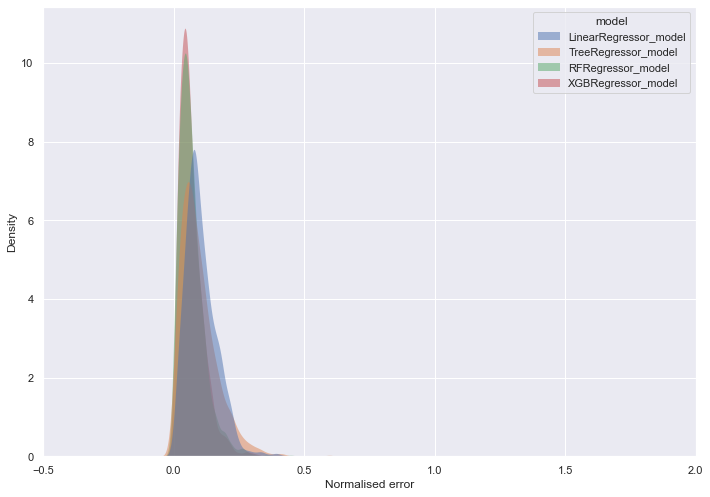

In [17]:
#Plot kde plot of normalised errors if computed
plt.xlim(-0.5, 2)
sns.set(rc={'figure.figsize':(11.7,8.27)})

#Kde plot
sns_plot = sns.kdeplot(
   data=error_df[error_df['model']!='NNRegressor_model'], x="Normalised error", hue="model",
   fill=True, common_norm=False,
   alpha=.5, linewidth=0,gridsize = 1000
)

#Save kde plot
fig = sns_plot.get_figure()
fig.savefig("100_point_normalised_error.png")

In [19]:
#Display mean and standard deviation of normalised error for each module
print('LinearRegressor:',error_df['LinearRegressor_model'].mean())
print(error_df['LinearRegressor_model'].std())

print('Tree Regressor:',error_df['TreeRegressor_model'].mean())
print(error_df['TreeRegressor_model'].std())

print('Random Forest:',error_df['RFRegressor_model'].mean())
print(error_df['RFRegressor_model'].std())

print('XGBoost:',error_df['XGBRegressor_model'].mean())
print(error_df['XGBRegressor_model'].std())

print('Neural Network:',error_df['NNRegressor_model'].mean())
print(error_df['NNRegressor_model'].std())

LinearRegressor: 0.10452657615442021
0.06072098144138995
Tree Regressor: 0.09686189840165131
0.07297235943878225
Random Forest: 0.06854643358100515
0.05182237193666468
XGBoost: 0.06744905447323993
0.049615201688543685
Neural Network: 0.13062314072662023
0.07837223671435789


In [ ]:
#Plot 2D visual representation of predicted and actual bifurcation points, along with corresponding connection points
plotdf = testdf.sample(n=3)

#Iterate over the n samples in the test data set
for index, row in plotdf.iterrows():
    
    #Specify x and y values of connection points
    x = [row['Px'],row['D1x'],row['D2x']]
    y = [row['Py'],row['D1y'],row['D2y']]

    #Specify x and y values of bifurcation prediction 
    pred_X = row['Bifx_pred_XGBRegressor_model']
    pred_Y = row['Bify_pred_XGBRegressor_model']

    #Specify x and y values of actual bifurcation point
    X = row['Bifx']
    Y = row['Bify']

    #Create a figure
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    #Plot all points
    ax1.scatter(x ,y, s=30, c='b', marker="s", label='Connection points')
    ax1.scatter(X,Y, s=30, c='k', marker="o", label='actual')
    ax1.scatter(pred_X,pred_Y, s=30, c='r', marker="o", label='pred')
    plt.legend(loc='upper left')

    #Save figure
    fig.savefig("1000_points_norm_sample_connection_sample" + str(index) + ".png")

## Feature selection
We will now use KBest feature selection and recursive feature elimination to find the most relevant features that give the highest CV score.
### Load Dataset

In [36]:
#Read dataset path as pandas dataframe
load_path = (os.getcwd() + "/ProcessedData/WP2T1/1000_seg_enriched_dataset.csv")
df = pd.read_csv(load_path,dtype={'beta': object})
df.head()

print('NaN count:',df.isna().values.sum())
print(df.shape)
df = df.dropna()
print('NaN count:',df.isna().values.sum())
df.shape

#Remove rows containing 'i' 
df = df[~df['beta'].str.contains("i")]

#Convert column 'beta' into a column of type float
df.beta = df.beta.astype(float)

#Define x and y range of allocated area
rangex = df[['Px','D1x','D2x']].max(axis=1) - df[['Px','D1x','D2x']].min(axis=1)
rangey = df[['Py','D1y','D2y']].max(axis=1) - df[['Py','D1y','D2y']].min(axis=1)

#Normalise connection points
df[['Bifx','Px','D1x','GPx','P2x']] = df[['Bifx','Px','D1x','GPx','P2x']].divide(rangex,axis=0)
df[['Bify','Py','D1y','GPy','P2y']] = df[['Bify','Py','D1y','GPy','P2y']].divide(rangey,axis=0)

#Remove NaN values
print('NaN count:',df.isna().values.sum())
df = df.dropna()

#Identify bifurcation point as target y (THIS CAN BE SET TO BIFX OR BIFY)
labels = ['Bifx']
y = df[labels] 

#identify features x
features = ['D1x', 'D1y', 'Px', 'Py','Radius','circleradius','totseg','P2x','P2y','GPx','GPy','OrigSeg','l1','l2','l3','beta','alpha']
X = df[features]

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33,random_state = 0)

y_train.shape

NaN count: 0
(99000, 22)
NaN count: 0
NaN count: 0


(66250, 1)

### Univariate feature selection
This finds the strength of linear correlation of individual features to a specified label (e.g. Bifx/Bify) 

In [17]:
#Carry out univariate feature selection using function SelectKBest
selected_features = SelectKBest(f_regression, k = 'all').fit(X, np.ravel(y))

#Create dataframe based on the feature and their score
selected_features_df = pd.DataFrame({'Feature':list(X.columns),
                                    'Scores':selected_features.scores_})

#Sort in order of importance
selected_features_df.sort_values(by='Scores',ascending=False)

,Feature,Scores
2,Px,610343.493110
0,D1x,210995.841836
9,GPx,3803.024221
7,P2x,493.133801
3,Py,68.057140
15,beta,62.555622
16,alpha,44.890329
6,totseg,29.271516
14,l3,21.848934
4,Radius,16.757452


As we can see, there are high linear correlations between the parent and sibling coordinates

### Recursive feature elimination
We first use RFE to find the importance of features (by rank) for the XGBoost model, and then prune out unecessary features based on their effects in the cross validation score using RFECV.

In [13]:
#Import relevant modules
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

#Define XGBoost model
model = XGBRegressor(n_estimators = 128)

#Use RFE to rank features based on importance to the model
rfe = RFE(estimator = model, step = 1,n_features_to_select=1)
rfe = rfe.fit(X,y)

In [14]:
#Print dataframe to show features and their ranking
selected_rfe_features = pd.DataFrame({'Feature':X.columns,
                                      'Ranking':rfe.ranking_})
selected_rfe_features.sort_values(by='Ranking')

,Feature,Ranking
3,Py,1
1,D1y,2
4,Radius,3
14,l3,4
11,OrigSeg,5
2,Px,6
0,D1x,7
10,GPy,8
8,P2y,9
12,l1,10


This also shows strong importance in parent and sibling connection points, but radius, l3 and origseg also look relatively importance

## Recursive feature elimination with cross validation
Here, we recursively eliminate features and observe the change in a 10-fold cross validation score. This can be used to identify how many features to keep. Sometimes the cross validation score decreases if there are features irrelevant to the output, other times its just better to remove features if they have little impact; this is to optimise computational performance.

Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitt

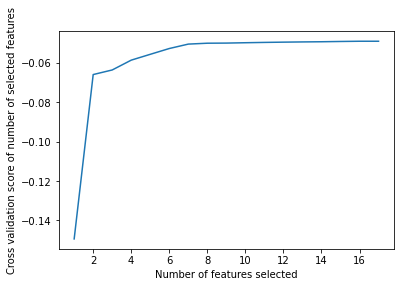

In [15]:
#Recursive feature elimination with cross validation, step = 1 means drop 1 feature every iteration)
rfecv = RFECV(estimator=model, step=1, cv=10, scoring='neg_mean_absolute_error',verbose = 1)
rfecv = rfecv.fit(X, y)

#Display the optimal number of features for best accuracy
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])
print(rfecv.grid_scores_)

#Plot graph to show the effect of features on cross validation score
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Although 16 features were found to be the optimum, we can see from the graph that the change in cross validation score is negligible after 8 features.

## Parameter Tuning
We will tune the parameters of the XGBoost model in the following order:

* Number of trees in forest
* Tree depth and minimum child weight
* Learning rate

#### Load Dataset

In [37]:
# XGBoost on dataset, Tune n_estimators
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot

#Read dataset path as pandas dataframe
load_path = (os.getcwd() + "/ProcessedData/WP2T1/1000_seg_enriched_dataset.csv")
df = pd.read_csv(load_path,dtype={'beta': object})
df.head()

print('NaN count:',df.isna().values.sum())
print(df.shape)
df = df.dropna()
print('NaN count:',df.isna().values.sum())
df.shape

#Remove rows containing 'i' 
df = df[~df['beta'].str.contains("i")]
#Convert column 'beta' into a column of type float
df.beta = df.beta.astype(float)

rangex = df[['Px','D1x','D2x']].max(axis=1) - df[['Px','D1x','D2x']].min(axis=1)
rangey = df[['Py','D1y','D2y']].max(axis=1) - df[['Py','D1y','D2y']].min(axis=1)

df[['Bifx','Px','D1x','GPx','P2x']] = df[['Bifx','Px','D1x','GPx','P2x']].divide(rangex,axis=0)
df[['Bify','Py','D1y','GPy','P2y']] = df[['Bify','Py','D1y','GPy','P2y']].divide(rangey,axis=0)

print('NaN count:',df.isna().values.sum())
df = df.dropna()

#Identify bifurcation points as target y
labels = ['Bifx']
y = df[labels] 

#identify features x
features = ['D1x', 'D1y', 'Px', 'Py','Radius','circleradius','totseg','P2x','P2y','GPx','GPy','OrigSeg','l1','l2','l3','beta','alpha']
X = df[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33,random_state = 0)

y_train.shape

NaN count: 0
(99000, 22)
NaN count: 0
NaN count: 0


(66250, 1)

#### Number of trees

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Best: -0.052327 using {'n_estimators': 175}
-0.052807 (0.000492) with: {'n_estimators': 50}
-0.052549 (0.000547) with: {'n_estimators': 75}
-0.052417 (0.000543) with: {'n_estimators': 100}
-0.052346 (0.000600) with: {'n_estimators': 125}
-0.052335 (0.000586) with: {'n_estimators': 150}
-0.052327 (0.000619) with: {'n_estimators': 175}
-0.052365 (0.000611) with: {'n_estimators': 200}
-0.052425 (0.000616) with: {'n_estimators': 225}
-0.052467 (0.000608) with: {'n_estimators': 250}
-0.052503 (0.000608) with: {'n_estimators': 275}
-0.052557 (0.000585) with: {'n_estimators': 300}
-0.052618 (0.000584) with: {'n_estimators': 325}
-0.052673 (0.000555) with: {'n_estimators': 350}
-0.052716 (0.000574) with: {'n_estimators': 375}


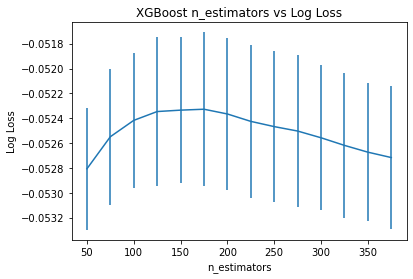

In [27]:
# grid search for 50 to 400 trees in increments of 25
model = XGBRegressor()
n_estimators = range(50, 400, 25)
param_grid = dict(n_estimators=n_estimators)
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_absolute_error", n_jobs=-1, cv=10,verbose=1)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
    
# plot cross validation score and error bar for each iteration
pyplot.errorbar(n_estimators, means, yerr=stds)
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.savefig('n_estimators.png')

#### Max tree depth and minimum child weight

In [33]:
# grid search using the optimum number of trees
model = XGBRegressor(n_estimators = 175)

#define grid search area
parameters = {
    'max_depth': [2 4 6 8 10 12 14]
    'min_child_weight':[1,3,5,7,9]
}

#Carry out grid search with 10-fold cross validation
grid_search = GridSearchCV(model, param_grid = parameters, scoring="neg_mean_absolute_error", n_jobs=-1, cv=10,verbose=1)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 35 candidates, totalling 350 fits
Best: -0.052313 using {'max_depth': 6, 'min_child_weight': 9}


#### Learning rate

In [38]:
# grid search
model = XGBRegressor(n_estimators = 175,max_depth = 6, min_child_weight = 9)
parameters = {
    'learning_rate': [0.5,0.3,0.1,0.05,0.03,0.01]
}
grid_search = GridSearchCV(model, param_grid = parameters, scoring="neg_mean_absolute_error", n_jobs=-1, cv=10,verbose=1)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best: -0.051875 using {'learning_rate': 0.1}


# Final Model Training

In [9]:
#Read dataset path as pandas dataframe
load_path = (os.getcwd() + "/ProcessedData/WP2T1/3000_seg_enriched_dataset.csv")
df = pd.read_csv(load_path,dtype={'beta': object})
df.head()

print('NaN count:',df.isna().values.sum())
print(df.shape)
df = df.dropna()
print('NaN count:',df.isna().values.sum())
df.shape

#Remove rows containing 'i' 
df = df[~df['beta'].str.contains("i")]
#Convert column 'beta' into a column of type float
df.beta = df.beta.astype(float)

rangex = df[['Px','D1x','D2x']].max(axis=1) - df[['Px','D1x','D2x']].min(axis=1)
rangey = df[['Py','D1y','D2y']].max(axis=1) - df[['Py','D1y','D2y']].min(axis=1)

df[['Bifx','Px','D1x','GPx','P2x']] = df[['Bifx','Px','D1x','GPx','P2x']].divide(rangex,axis=0)
df[['Bify','Py','D1y','GPy','P2y']] = df[['Bify','Py','D1y','GPy','P2y']].divide(rangey,axis=0)

print('NaN count:',df.isna().values.sum())
df = df.dropna()

#Identify bifurcation points as target y
labels = ['Bifx','Bify']
y = df[labels] 

#identify features x
features = ['D1x', 'D1y', 'Px', 'Py','Radius','GPx','GPy','OrigSeg','l3']
X = df[features]

from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

#Define regression models

XGBRegressor_model = MultiOutputRegressor(XGBRegressor(n_estimators = 175,learning_rate = 0.1,max_depth= 6, min_child_weight = 9))

NaN count: 0
(299000, 22)
NaN count: 0
NaN count: 3


In [13]:
#10 fold cross validation
score = -(cross_val_score(XGBRegressor_model,X,y,cv=10,scoring='neg_mean_absolute_error'))

In [3]:
#Print cross validation score
print(score.mean())

NameError: name 'score' is not defined